In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sampex_microburst_indices.load.catalog import Catalog
from sampex_microburst_indices.id.index_intervals import get_index_intervals

/home/mike/research/sampex_microburst_indices/env/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


Load the CSV file, parse the time stamps, remove rows with unfilled attitude data, and removes spin times.

In [2]:
cat = Catalog(0, parse_dates=True).load()

In [3]:
print(cat.columns, '\n', cat.shape)

Index(['burst_param', 'date', 'GEO_Long', 'GEO_Lat', 'Altitude', 'L_Shell',
       'MLT', 'Att_Flag', 'Pitch', 'AE', 'AL', 'AU', 'SYM/D', 'SYM/H', 'ASY/D',
       'ASY/H'],
      dtype='object') 
 (244020, 16)


In [4]:
cat.head()

,burst_param,date,GEO_Long,GEO_Lat,Altitude,L_Shell,MLT,Att_Flag,Pitch,AE,AL,AU,SYM/D,SYM/H,ASY/D,ASY/H
dateTime,,,,,,,,,,,,,,,,
1997-11-09 19:56:40.720,35.3,1997-11-09,108.686,69.4370,681.303,5.47977,3.30990,0.0,32.9061,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:56:46.920,16.5,1997-11-09,109.084,69.1038,681.373,5.34191,3.33664,0.0,32.8835,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:57:02.440,10.4,1997-11-09,110.202,68.0984,681.558,4.99033,3.41316,0.0,32.8191,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:57:02.760,10.2,1997-11-09,110.202,68.0984,681.558,4.99033,3.41316,0.0,32.8191,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:57:02.980,10.4,1997-11-09,110.202,68.0984,681.558,4.99033,3.41316,0.0,32.8191,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0


In [22]:
cat['dt'] = cat.index.to_series().diff().dt.total_seconds()
cat = cat.dropna()
cat['dt']

dateTime
1997-11-09 19:56:46.920         6.20
1997-11-09 19:57:02.440        15.52
1997-11-09 19:57:02.760         0.32
1997-11-09 19:57:02.980         0.22
1997-11-09 19:57:09.720         6.74
                             ...    
2007-08-11 19:25:55.640         6.76
2007-08-11 19:25:55.900         0.26
2007-08-11 19:25:55.940         0.04
2007-08-11 19:25:56.240         0.30
2007-08-22 14:22:12.900    932176.66
Name: dt, Length: 244019, dtype: float64

The peak of the dt distribution is at 0.327 s.


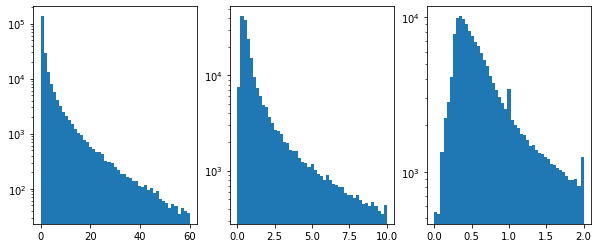

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(cat['dt'], bins=np.linspace(0, 60))
ax[1].hist(cat['dt'], bins=np.linspace(0, 10))
ax[2].hist(cat['dt'], bins=np.linspace(0, 2));

for ax_i in ax:
    ax_i.set_yscale('log');

H, bins = np.histogram(cat['dt'], bins=np.linspace(0, 2))
print(f'The peak of the dt distribution is at {round(bins[np.argmax(H)], 3)} s.')


As we zoomed in, we found that the dt distribution is peaked at ~0.3 seconds.

In [24]:
np.nanquantile(cat['dt'], q=(0.25, .50, 0.75))

array([0.46, 0.96, 4.2 ])

# Calculate the microburst trains
First define a maximum time threshold between microbursts to qualify as a microburst train

In [25]:
threshold_s = 1
train_indices = np.where(cat['dt'] <= threshold_s)[0]
start_interval, end_interval = get_index_intervals(train_indices)

In [26]:
start_interval

array([     0,      2,      3, ..., 125340, 125341, 125344])

In [27]:
end_interval

array([     2,      3,      6, ..., 125341, 125344, 125347])

## Validate groups

In [38]:
max_index = 20
cat_copy = cat.iloc[:max_index].copy()
cat_copy['ind'] = np.arange(max_index)
cat_copy.iloc[:max_index][['dt', 'ind']]

,dt,ind
dateTime,,
1997-11-09 19:56:46.920,6.20,0
1997-11-09 19:57:02.440,15.52,1
1997-11-09 19:57:02.760,0.32,2
1997-11-09 19:57:02.980,0.22,3
1997-11-09 19:57:09.720,6.74,4
1997-11-09 20:42:16.280,2706.56,5
1997-11-10 00:31:21.700,13745.42,6
1997-11-10 00:47:48.780,987.08,7
1997-11-10 01:20:27.020,1958.24,8


With threshold less than 1 s, there should be three trains: microbursts on rows 1-3, 11-12, 13-16. Other intervals are for single microbusts.

In [52]:
validate_n = 5

for start, end in zip(start_interval[:validate_n], end_interval[:validate_n]):
    print(cat_copy.iloc[start:end]['dt'])

dateTime
1997-11-09 19:56:46.920     6.20
1997-11-09 19:57:02.440    15.52
Name: dt, dtype: float64
dateTime
1997-11-09 19:57:02.760    0.32
Name: dt, dtype: float64
dateTime
1997-11-09 19:57:02.980       0.22
1997-11-09 19:57:09.720       6.74
1997-11-09 20:42:16.280    2706.56
Name: dt, dtype: float64
dateTime
1997-11-10 00:31:21.700    13745.42
Name: dt, dtype: float64
dateTime
1997-11-10 00:47:48.780     987.08
1997-11-10 01:20:27.020    1958.24
Name: dt, dtype: float64


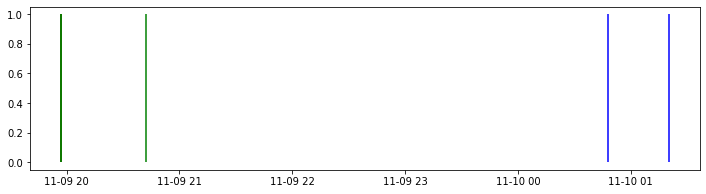

In [44]:
validate_n = 5
colors = itertools.cycle('rgbkc')
fig, bx = plt.subplots(figsize=(12, 3))

for start, end in zip(start_interval[:validate_n], end_interval[:validate_n]):
    if end-start == 1:
        continue
    bx.vlines(cat.iloc[start:end].index, 0, 1, colors=next(colors))